## Business case
### Help stakeholder to make better financial decisions regarding selling and renovating houses with the potential for big investment returns according to data analysis in order to setup modeling for forecast 

## Import Cleaned data 

In [1]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import operator
# import to divide our data into train and test data
from sklearn.model_selection import train_test_split
# import to create polynomial features
from sklearn.preprocessing import PolynomialFeatures
# import of the linear regression model
from sklearn.linear_model import LinearRegression
# import of our evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score

RSEED = 12

In [3]:
data_model=pd.read_csv('data/model_data.csv')
data_model.head()

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,lat,long,sqft_living15,sqft_lot15,sold_year,sold_month,sold_day,new_renovate,Age_house,new_id
0,0,7129300520,2014-10-13,221900.000,3,1.000,1180,5650,1.000,NaN,...,47.511,-122.257,1340,5650,2014,10,0,0,61,1
1,1,6414100192,2014-12-09,538000.000,3,2.250,2570,7242,2.000,0.000,...,47.721,-122.319,1690,7639,2014,12,1,1,65,1
2,2,5631500400,2015-02-25,180000.000,2,1.000,770,10000,1.000,0.000,...,47.738,-122.233,2720,8062,2015,2,2,2,83,1
3,3,2487200875,2014-12-09,604000.000,4,3.000,1960,5000,1.000,0.000,...,47.521,-122.393,1360,5000,2014,12,1,0,51,1
4,4,1954400510,2015-02-18,510000.000,3,2.000,1680,8080,1.000,0.000,...,47.617,-122.045,1800,7503,2015,2,2,0,29,1


## Split Data Training and Test

In [4]:
# Split data into train and test set
import sklearn.model_selection
X =data_model[['sqft_living','bedrooms']] ## as we have good correlation between price and sqft_living and price and bedrooms
y=data_model['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RSEED)

## Modeling 
### First model: linear regression

In [5]:
# Instantiate our model 

lin_reg = LinearRegression()
# Fit the model using our train data 
lin_reg.fit(X_train, y_train)

# Make predictions on the test data and save those in "y_pred"

y_pred_test = lin_reg.predict(X_test)
y_pred_train = lin_reg.predict(X_train)

In [6]:
from function import calculate_metrics
print("Linear Regression Model:")
print("---"*10)
calculate_metrics(y_train,y_pred_train, y_test, y_pred_test)  # The optomal RMSE IS ZERO 

Linear Regression Model:
------------------------------
Metrics on training data
RMSE: 258760.848
R2: 0.508
------------------------------
Metrics on test data
RMSE: 255657.177
R2: 0.505
------------------------------


### RMSE value in traning data higher than RMSR value in test data that mean our model can handling the actual value better and its has good regularization .

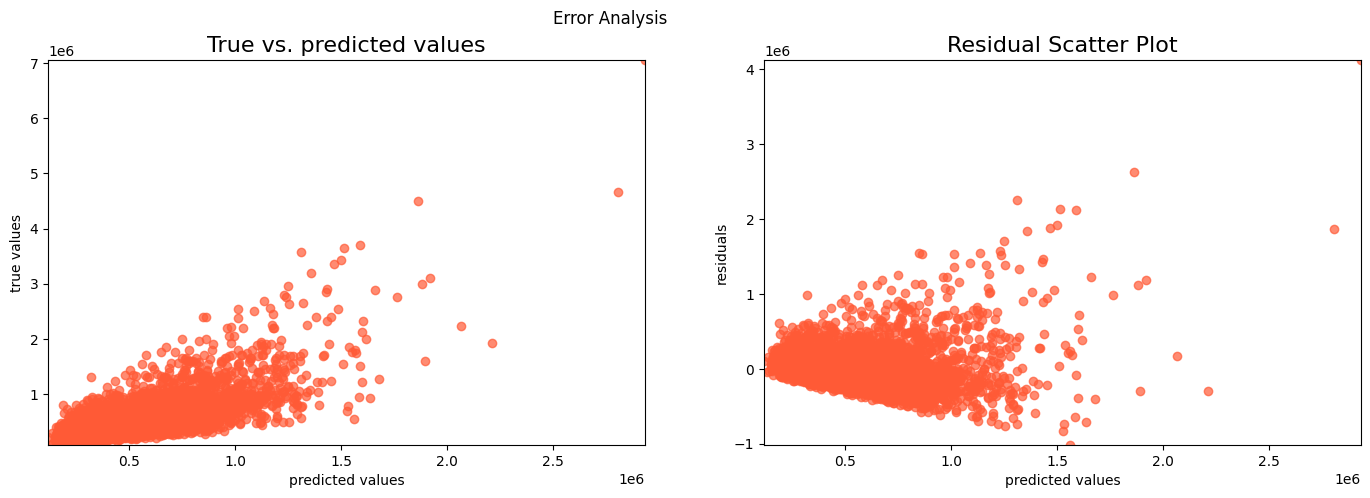

In [7]:
from function import error_analysis
error_analysis(y_test, y_pred_test)

### Second model: linear regression with polynomial features to increase complexity to our model 

In [8]:
# here we will add the second degree polynomial features to increase complexity to our model 
polynomial_features = PolynomialFeatures(degree=2, include_bias=False)
x_poly_train = polynomial_features.fit_transform(X_train)
x_poly_test = polynomial_features.transform(X_test)

model_poly = LinearRegression()
model_poly.fit(x_poly_train, y_train)
y_pred_test = model_poly.predict(x_poly_test)
y_pred_train = model_poly.predict(x_poly_train)

In [9]:
print("Polynomial Regression Model (degree 2):")
print("---"*10)
calculate_metrics(y_train,y_pred_train, y_test, y_pred_test)

Polynomial Regression Model (degree 2):
------------------------------
Metrics on training data
RMSE: 251095.131
R2: 0.536
------------------------------
Metrics on test data
RMSE: 244749.039
R2: 0.546
------------------------------


## Tune Hyperparameter 

#### Define model like  LinearRegression not work ,because hyperparameter search using RandomizedSearchCV to a LinearRegression model from scikit-learn, and some of the hyperparameters you're trying to optimize ('n_jobs', 'positive', etc.) are not applicable or valid for LinearRegression.
### So we can use Ridge or Lasso instead 


In [10]:

from scipy.stats import loguniform

from sklearn.linear_model import Ridge
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV

# define model
model = Ridge()
# define evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define search space
space = dict()
space['solver'] = ['svd', 'cholesky', 'lsqr', 'sag']
space['alpha'] = loguniform(1e-5, 100)
space['fit_intercept'] = [True, False]
space['random_state'] = [True, False]
# define search
search = RandomizedSearchCV(model, space, n_iter=500, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv, random_state=1)
# execute search
result = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

/Users/anas/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/anas/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/anas/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/anas/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/anas/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/User

Best Score: -170659.73450081918
Best Hyperparameters: {'alpha': 1.0418993786562532e-05, 'fit_intercept': True, 'random_state': False, 'solver': 'svd'}


/Users/anas/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [11]:
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: -170659.73450081918
Best Hyperparameters: {'alpha': 1.0418993786562532e-05, 'fit_intercept': True, 'random_state': False, 'solver': 'svd'}


In [12]:
# Instantiate our model with Hyperparameter

ridge_model = Ridge(alpha=1.0418993786562532e-05,solver='svd',fit_intercept=True,random_state=False)


In [13]:

# Fit the model using our train data 
ridge_model.fit(X_train, y_train)

# Make predictions on the test data and save those in "y_pred"

y_pred_test = ridge_model.predict(X_test)
y_pred_train = ridge_model.predict(X_train)

In [14]:
print("results of Ridge model with Hyperparameter ")
print("---"*10)
calculate_metrics(y_train,y_pred_train, y_test, y_pred_test)

results of Ridge model with Hyperparameter 
------------------------------
Metrics on training data
RMSE: 258760.848
R2: 0.508
------------------------------
Metrics on test data
RMSE: 255657.177
R2: 0.505
------------------------------


In [15]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred_test)  
print(f"Mean Squared Error: {mse}")



Mean Squared Error: 65360592204.61875
